<a name="TOC"></a>
# Dynamics Tutorial 4: Scattering on 3 Tully's models

In this tutorial we will learn:

* how to run scattering NA-MD calculations on 3 Tully's models

TOC:

1. [Define models](#define_models)
2. [Auxiliary functons](#aux_functions)
3. [Tully-3](#Tully-3)
 
 3.1. [Diabatic PES scan](#Tully-3-dia)
 
 3.2. [Numeric Adiabatic PES scan](#Tully-3-adi)
 
 3.3. [FSSH](#Tully-3-fssh)


 
 

In [1]:
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py.models import Tully
from libra_py.models import Holstein
from libra_py import tsh
from libra_py import tsh_stat
from libra_py import tsh_algo1
from libra_py import dynamics
from libra_py import dynamics_io
from libra_py import data_conv
from libra_py import data_read


import matplotlib.pyplot as plt   # plots
import numpy as np
#from matplotlib.mlab import griddata

%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, s

<a name="define_models"></a>
[Back to TOC](#TOC)

## 1. Define the models

First, lets defined the model Hamiltonians in the diabatic and diabatic representation. This part has been covered in the previous tutorials. 

As before, we use a 2-state spin-boson Hamiltonian, which can be written in adiabatic representation analytically. 

The call of the file-based Hamiltonian "calculation" function will be made when we select the **model**  parameter to take the value of 3

In [2]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    Id = Cpp2Py(full_id)
    indx = Id[-1]

    x = q.col(indx).get(0)
    _q = MATRIX(1,1); _q.set(0,0, x)
    
    if model==1:        
        res = Tully.Tully1(_q, params)
        
    elif model==2:
        res = Tully.Tully2(_q, params)
                
    elif model==3: 
        res = Tully.Tully3(_q, params)
        

    return res


<a name="aux_functions"></a>
[Back to TOC](#TOC)

## 2. Auxiliary functions


<a name="pes_plot"></a>
[Back to TOC](#TOC)
### 2.1. Plotting PES/properties

In [3]:
def plot_properties(grid, comp_model, model_params, dyn_params):

    ndia, nadi, ndof = 2, 2, 1
    
    rep_tdse = dyn_params["rep_tdse"]  # what we want

    # ======= Hierarchy of Hamiltonians =======
    tol = 0.01
    ham = nHamiltonian(ndia, nadi, ndof)
    ham.init_all(2)
    ham.phase_corr_ovlp_tol = tol

    ham1 = [] 
    for tr in range(1):
        ham1.append( nHamiltonian(ndia, nadi, ndof) )        
        ham1[tr].init_all(2)
        ham1[tr].phase_corr_ovlp_tol = tol
        ham.add_child(ham1[tr])
        
    

    # Energies, forces, and couplings    
    H00, H11, H01 = [], [], []
    dH00, dH11, dH01 = [], [], []
    d01 = []
    
    nsteps = len(grid)
    
    tid = Py2Cpp_int([0, 0])
    
    for i in range(nsteps):
        q = MATRIX(1,1); q.set(0, 0, grid[i])
    
        update_Hamiltonian_q(dyn_params, q, ham, compute_model, model_params)
        
        if rep_tdse==0:    
            H00.append(ham.get_ham_dia(tid).get(0,0).real)
            H11.append(ham.get_ham_dia(tid).get(1,1).real)
            H01.append(ham.get_ham_dia(tid).get(0,1).real)    
    
            
            dH00.append(ham.get_d1ham_dia(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_dia(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_dia(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_dia(0,tid).get(0,1).real)
            
        elif rep_tdse==1:    
            H00.append(ham.get_ham_adi(tid).get(0,0).real)
            H11.append(ham.get_ham_adi(tid).get(1,1).real)
            H01.append(ham.get_ham_adi(tid).get(0,1).real)    
    
            dH00.append(ham.get_d1ham_adi(0,tid).get(0,0).real)
            dH11.append(ham.get_d1ham_adi(0,tid).get(1,1).real)            
            dH01.append(ham.get_d1ham_adi(0,tid).get(0,1).real) 
            
            d01.append(ham.get_dc1_adi(0,tid).get(0,1).real)            
            
            
    #======== Now lets plot what we have computed ===========
    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,3,1)
    plt.title('Energies and couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(grid, H00, label='H00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, H11, label='H11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, H01, label='H01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(1,3,2)
    plt.title('Derivatives')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, dH00, label='dH00', linewidth=2, color = colors["11"]) 
    plt.plot(grid, dH11, label='dH11', linewidth=2, color = colors["21"]) 
    plt.plot(grid, dH01, label='dH01', linewidth=2, color = colors["31"]) 
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.title('Derivative couplings')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Energy, a.u./Bohr')
    plt.plot(grid, d01, label='d01', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

<a name="dyn_plot"></a>
[Back to TOC](#TOC)

### 2.2. Plotting the results of dynamical calculations

In [4]:
def plot_dyn(res):
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13       14         15             16          17
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states obs_hvib_adi obs_hvib_dia  obs_St

    obs_T = res[0]
    obs_Ekin = res[3]
    obs_Epot = res[4]
    obs_Etot = res[5]
    obs_dEkin = res[6]
    obs_dEpot = res[7]
    obs_dEtot = res[8]
    obs_dm_adi00 = data_conv.unpack1(res[11], 0, 0, 0)
    obs_dm_adi11 = data_conv.unpack1(res[11], 1, 1, 0)
    obs_dm_dia00 = data_conv.unpack1(res[12], 0, 0, 0)
    obs_dm_dia11 = data_conv.unpack1(res[12], 1, 1, 0)
    obs_pop00 = data_conv.unpack1(res[13], 0, 0, 2)
    obs_pop11 = data_conv.unpack1(res[13], 1, 0, 2)
    obs_q = data_conv.unpack1(res[1], 0, 0, 2)
    obs_p = data_conv.unpack1(res[2], 0, 0, 2)
    
    ndof = res[1][0].num_of_rows
    ntraj = res[1][0].num_of_cols
    

    plt.figure(1, figsize=(24, 24)) # dpi=300, frameon=False)

    plt.subplot(3,2,1)
    plt.title('q-t')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Coordiante, a.u.')
    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        plt.plot(obs_T, obs_q, label="", linewidth=2, color = colors["11"])   # label='q vs. t'
    plt.legend()

    plt.subplot(3,2,2)
    plt.title('Phase portrait')
    plt.xlabel('Coordinate, a.u.')
    plt.ylabel('Momentum, a.u.')    
    for tr in range(ntraj):
        obs_q = data_conv.unpack1(res[1], 0, tr, 2)
        obs_p = data_conv.unpack1(res[2], 0, tr, 2)
        plt.plot(obs_q, obs_p, linewidth=2, color = colors["11"])  # label='p vs. q'
    plt.legend()

    plt.subplot(3,2,3)
    plt.title('Adiabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_pop00, "--o", label='SH P(0)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi00, "--o", label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_pop11, "--", label='SH P(1)', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dm_adi11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,4)
    plt.title('Diabatic populations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Population of state 0')
    plt.plot(obs_T, obs_dm_dia00, label='SE P(0)', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dm_dia11, "--", label='SE P(1)', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(3,2,5)
    plt.title('Energies')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_Ekin, label='Ekin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_Epot, label='Epot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_Etot, label='Etot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.subplot(3,2,6)
    plt.title('Energy fluctuations')
    plt.xlabel('Time, a.u.')
    plt.ylabel('Energy, a.u.')
    plt.plot(obs_T, obs_dEkin, label='dEkin', linewidth=2, color = colors["11"]) 
    plt.plot(obs_T, obs_dEpot, label='dEpot', linewidth=2, color = colors["21"]) 
    plt.plot(obs_T, obs_dEtot, label='dEtot', linewidth=2, color = colors["31"]) 
    plt.legend()

    plt.show()
    plt.close()

<a name="scattering-func"></a>
[Back to TOC](#TOC)

### 2.3. Scattering function

Here we define a function to run the scattering calculations for a range of initial conditions

In [5]:
def plot_scattering(init_cond, scan_res, scat_params):
    """
    scat_params = {"act_dof":0, "left_boundary":-5.0, "right_boundary":5.0}
    """
    
    # Format: 
    #   0      1      2       3        4        5           6          7        8            9       10        11            12        13        14 
    #obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop  obs_states
    # scan_res[icond][ivar][istep][i]       for lists
    # scan_res[icond][ivar][istep].get(i,j) for matrices    
    
    ncond = len(init_cond)
    P_re, P_tr, P0 = [], [], []

    for icond in range(ncond):
    
        P0.append(init_cond[icond][1][0])
        
        last_q = scan_res[icond][1][-1]
        last_states = scan_res[icond][14][-1]

        pop_refl, pop_transm = tsh_algo1.probabilities_1D_scattering(last_q, last_states, 2, scat_params )
        P_re.append(pop_refl)
        P_tr.append(pop_transm)

    p_re0 = data_conv.unpack1(P_re, 0, 0, 2)
    p_re1 = data_conv.unpack1(P_re, 1, 0, 2)
    p_tr0 = data_conv.unpack1(P_tr, 0, 0, 2)
    p_tr1 = data_conv.unpack1(P_tr, 1, 0, 2)

    plt.figure(1, figsize=(24, 12)) # dpi=300, frameon=False)
    plt.subplot(1,2,1)
    plt.title('Reflection Probabilities')
    plt.xlabel('Momentum, a.u.')
    plt.ylabel('Population')
    plt.plot(P0, p_re0, label='on state 0', linewidth=2, color = colors["11"]) 
    plt.plot(P0, p_re1, label='on state 1', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Transmission Probabilities')
    plt.xlabel('Momentum, a.u.')
    plt.ylabel('Population')
    plt.plot(P0, p_tr0, label='on state 0', linewidth=2, color = colors["11"]) 
    plt.plot(P0, p_tr1, label='on state 1', linewidth=2, color = colors["21"]) 
    plt.legend()

    plt.show()
    plt.close()    


<a name="reading-files"></a>
[Back to TOC](#TOC)

### 2.4. Read the files and reconstruct the objects to be plotted

Here, we define a function to read the files produces in a previous run and return the object we would normally return in the on-the-fly calculations, so that we can print the results.

In [6]:
def read_results(prefix, file_output_level, nadi, ndia, ndof, ntraj):
    
    obs_T = None
    obs_q, obs_p = None, None
    obs_Ekin, obs_Epot, obs_Etot = None, None, None
    obs_dEkin, obs_dEpot, obs_dEtot = None, None, None
    obs_Cadi, obs_Cdia = None, None 
    obs_dm_adi, obs_dm_dia = None, None
    obs_pop, obs_states = None, None
    obs_hvib_adi, obs_hvib_dia, obs_St, obs_U = None, None, None, None

    
    if file_output_level >= 1:
        res = data_read.get_data_from_file2("%s/energies.txt" % (prefix), range(0, 7) )
        obs_T = res[0]
        obs_Ekin = res[1]
        obs_Epot = res[2]
        obs_Etot = res[3]
        obs_dEkin = res[4]
        obs_dEpot = res[5]
        obs_dEtot = res[6]
                
        obs_dm_adi = dynamics_io.file2cmatrix("%s/D_adi.txt" % (prefix), nadi, nadi)
        obs_dm_dia = dynamics_io.file2cmatrix("%s/D_dia.txt" % (prefix), ndia, ndia)
        obs_pop = dynamics_io.file2matrix("%s/SH_pop.txt" % (prefix), nadi, 1)
        
    if file_output_level >= 2:
        obs_q = dynamics_io.file2matrix("%s/q.txt" % (prefix), ndof, ntraj)
        obs_p = dynamics_io.file2matrix("%s/p.txt" % (prefix), ndof, ntraj)
        obs_C_adi = dynamics_io.file2cmatrix("%s/C_adi.txt" % (prefix), nadi, ntraj)
        obs_C_dia = dynamics_io.file2cmatrix("%s/C_dia.txt" % (prefix), ndia, ntraj)
        obs_states = dynamics_io.file2intlist("%s/states.txt" % (prefix))       
        
    if file_output_level >= 3:
        obs_hvib_adi, obs_hvib_dia, obs_St, obs_U = [], [], [], []
        for tr in range(ntraj):                        
            hvib_adi = dynamics_io.file2cmatrix("%s/Hvib_adi_%i.txt" % (prefix, tr), nadi, nadi)
            hvib_dia = dynamics_io.file2cmatrix("%s/Hvib_dia_%i.txt" % (prefix, tr), nadi, nadi)
            St = dynamics_io.file2cmatrix("%s/St_%i.txt" % (prefix, tr), nadi, nadi)
            U = dynamics_io.file2cmatrix("%s/basis_transform_%i.txt" % (prefix, tr), ndia, nadi)
            
            obs_hvib_adi.append(hvib_adi)
            obs_hvib_dia.append(hvib_dia)
            obs_St.append(St)
            obs_U.append(U)                


    return obs_T, obs_q, obs_p, obs_Ekin, obs_Epot, obs_Etot, obs_dEkin, obs_dEpot, obs_dEtot, \
           obs_Cadi, obs_Cdia, obs_dm_adi, obs_dm_dia, obs_pop, obs_states, obs_hvib_adi, obs_hvib_dia, obs_St, obs_U
        

And another version - the one that would read the results of several setups

In [7]:
def read_results_multi(prefix, file_output_level, nadi, ndia, ndof, ntraj, nsets):
    
    res = []
    for iset in range(nsets):
        
        prefix_i = F"{prefix}_{iset}"
        res_i = read_results(prefix_i, file_output_level, nadi, ndia, ndof, ntraj)
        
        res.append(res_i)
        
    return res


In [8]:
xmin = -10.0
xmax = 10.0
dx = 0.1

X = []
nsteps = int((xmax - xmin) / dx) + 1

for i in range(nsteps):
    X.append(xmin + i * dx)

<a name="Tully-3"></a>
[Back to TOC](#TOC)

## 3. Tully Model 3

<a name="Tully-3-dia"></a>
[Back to TOC](#TOC)

### 3.1. Diabatic PES scan

We want diabatic properties and the model Hamiltonian does return the diabatic properties

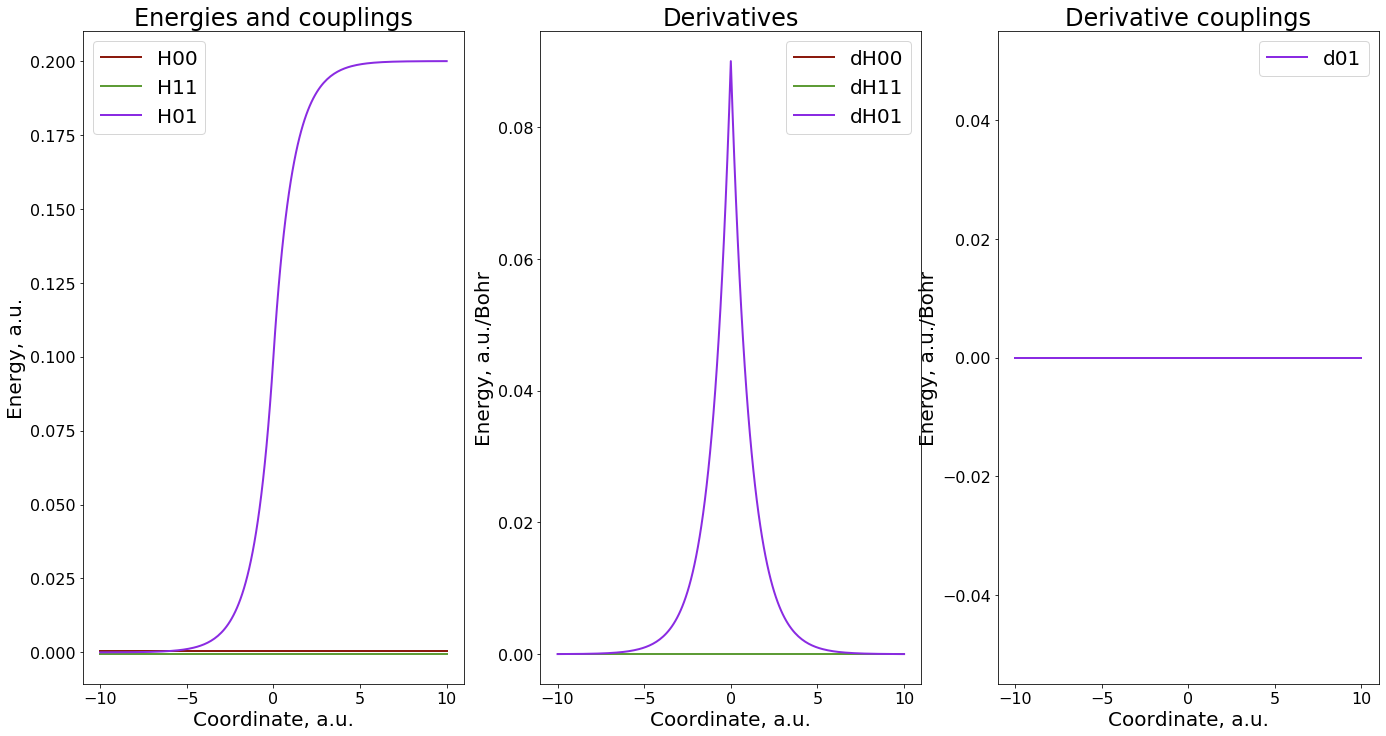

In [9]:
plot_properties(X, compute_model, {"model":3}, {"rep_tdse":0, "rep_ham":0} )

<a name="Tully-3-adi"></a>
[Back to TOC](#TOC)

### 3.2. Adiabatic PES scan

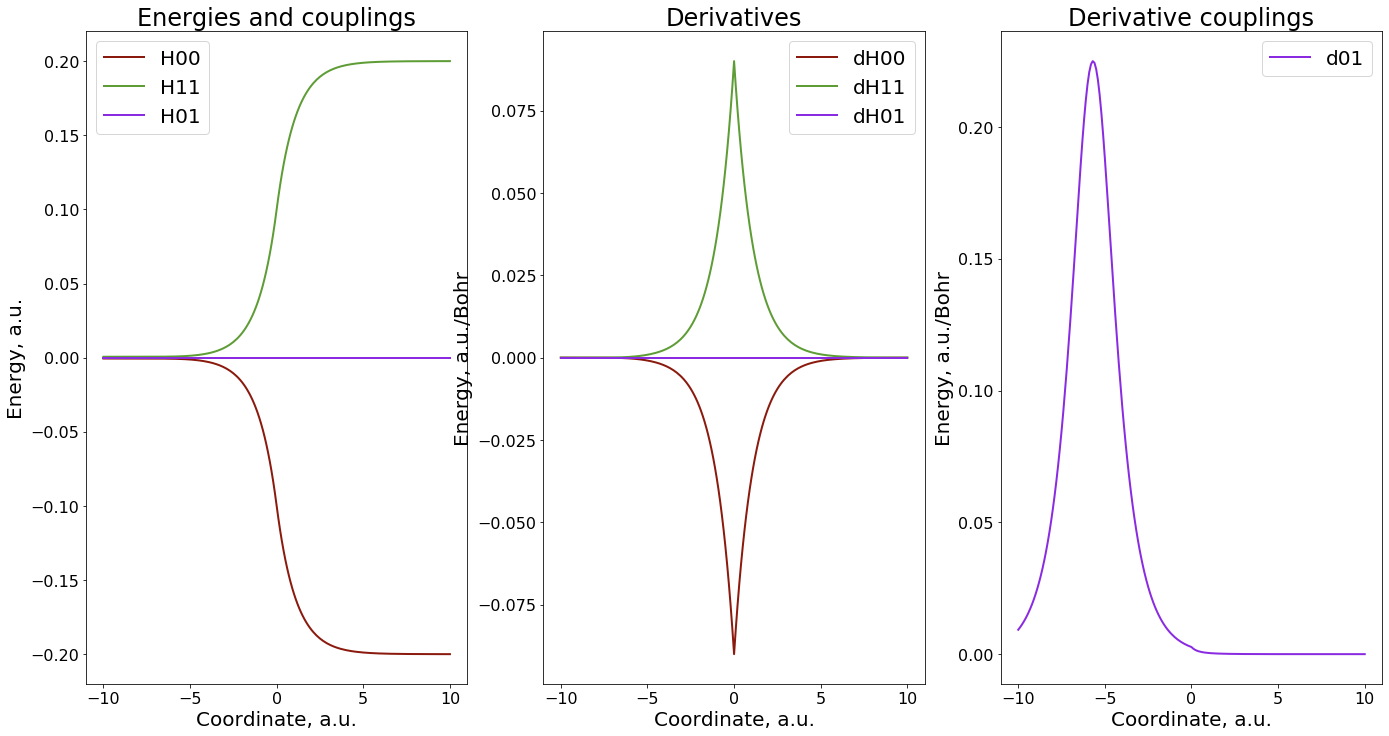

In [10]:
plot_properties(X, compute_model, {"model":3, "model0":0}, {"rep_tdse":1, "rep_ham":0} )

<a name="Tully-3-fssh"></a>
[Back to TOC](#TOC)

### 3.3. FSSH dynamics

Following the prescriptions of the previous tutorials, the parameters to run the TSH dynamics would be as follows:

In [11]:
# Random numbers generator object
rnd = Random()

ntraj = 10
    
init_cond = []
for p0 in [5.0, 10.0]:
    init_cond.append([ [-15.0], [p0], [2000.0] ])
    
# For FSSH
dyn_params = { "rep_tdse":1, "rep_ham":0, "rep_sh":1, "rep_lz":0, "tsh_method":2,
               "force_method":1, "nac_update_method":1, "rep_force":1,
               "use_boltz_factor":0, "Temperature":300.0, "do_reverse":1, "vel_rescale_opt":0,
               "do_phase_correction":1, "tol":1e-3,
               "state_tracking_algo":2, "MK_alpha":0.0, "MK_verbosity":0, 
               "entanglement_opt":0, "ETHD3_alpha":0.0, "ETHD3_beta":0.0, 
               "dt":0.1*units.fs2au, "nsteps":1000, 
               "output_level":2, "file_output_level":-1, "prefix":"T_test1"
              }
# Tully-1
model_params = {"model":3, "model0":3}

# Initialize electronic variables
init_elec = { "init_type":3, "nstates":2, "istates":[1.0, 0.0], "rep":1,  "ntraj":ntraj   }

# Initialize nuclear variables
init_nucl = { "init_type":3, "force_constant":[0.001], "ntraj":ntraj}


# If you want to recompute all
res3 = dynamics.run_multiple_sets(init_cond, dyn_params, compute_model, model_params, init_nucl, init_elec, rnd)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


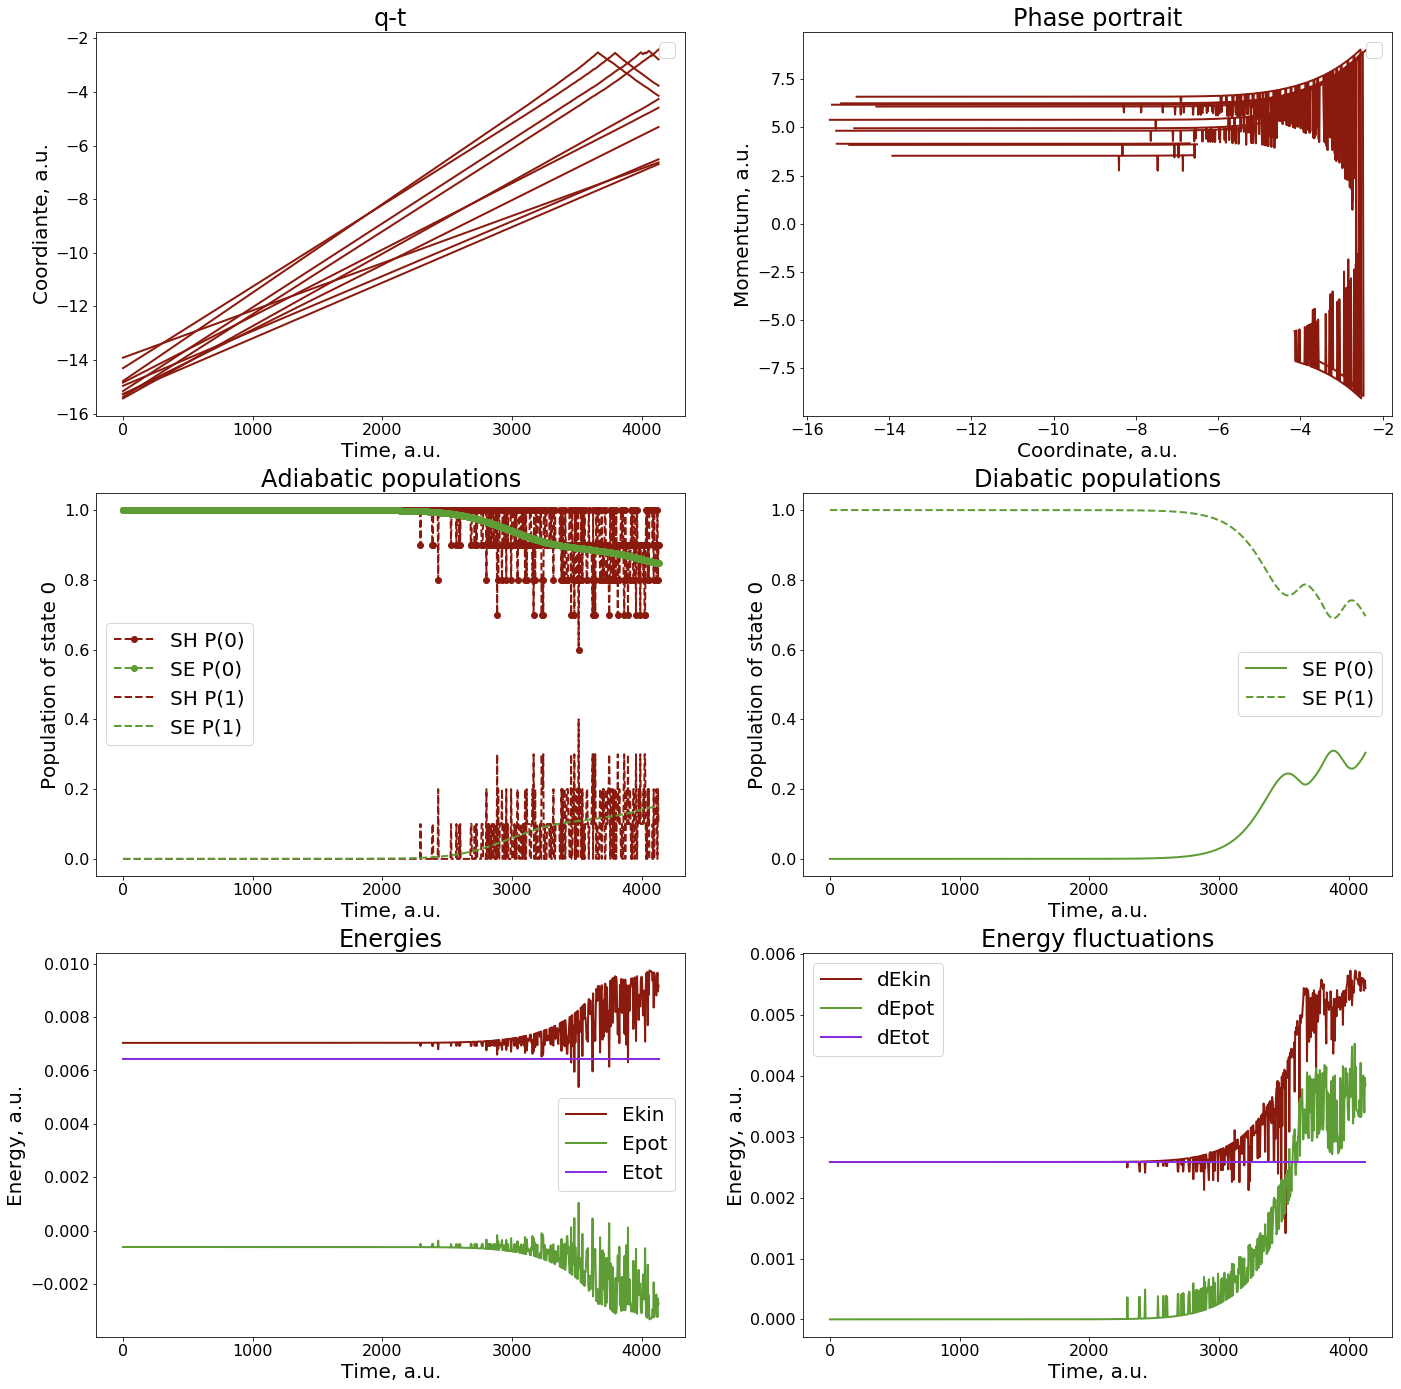

No handles with labels found to put in legend.
No handles with labels found to put in legend.


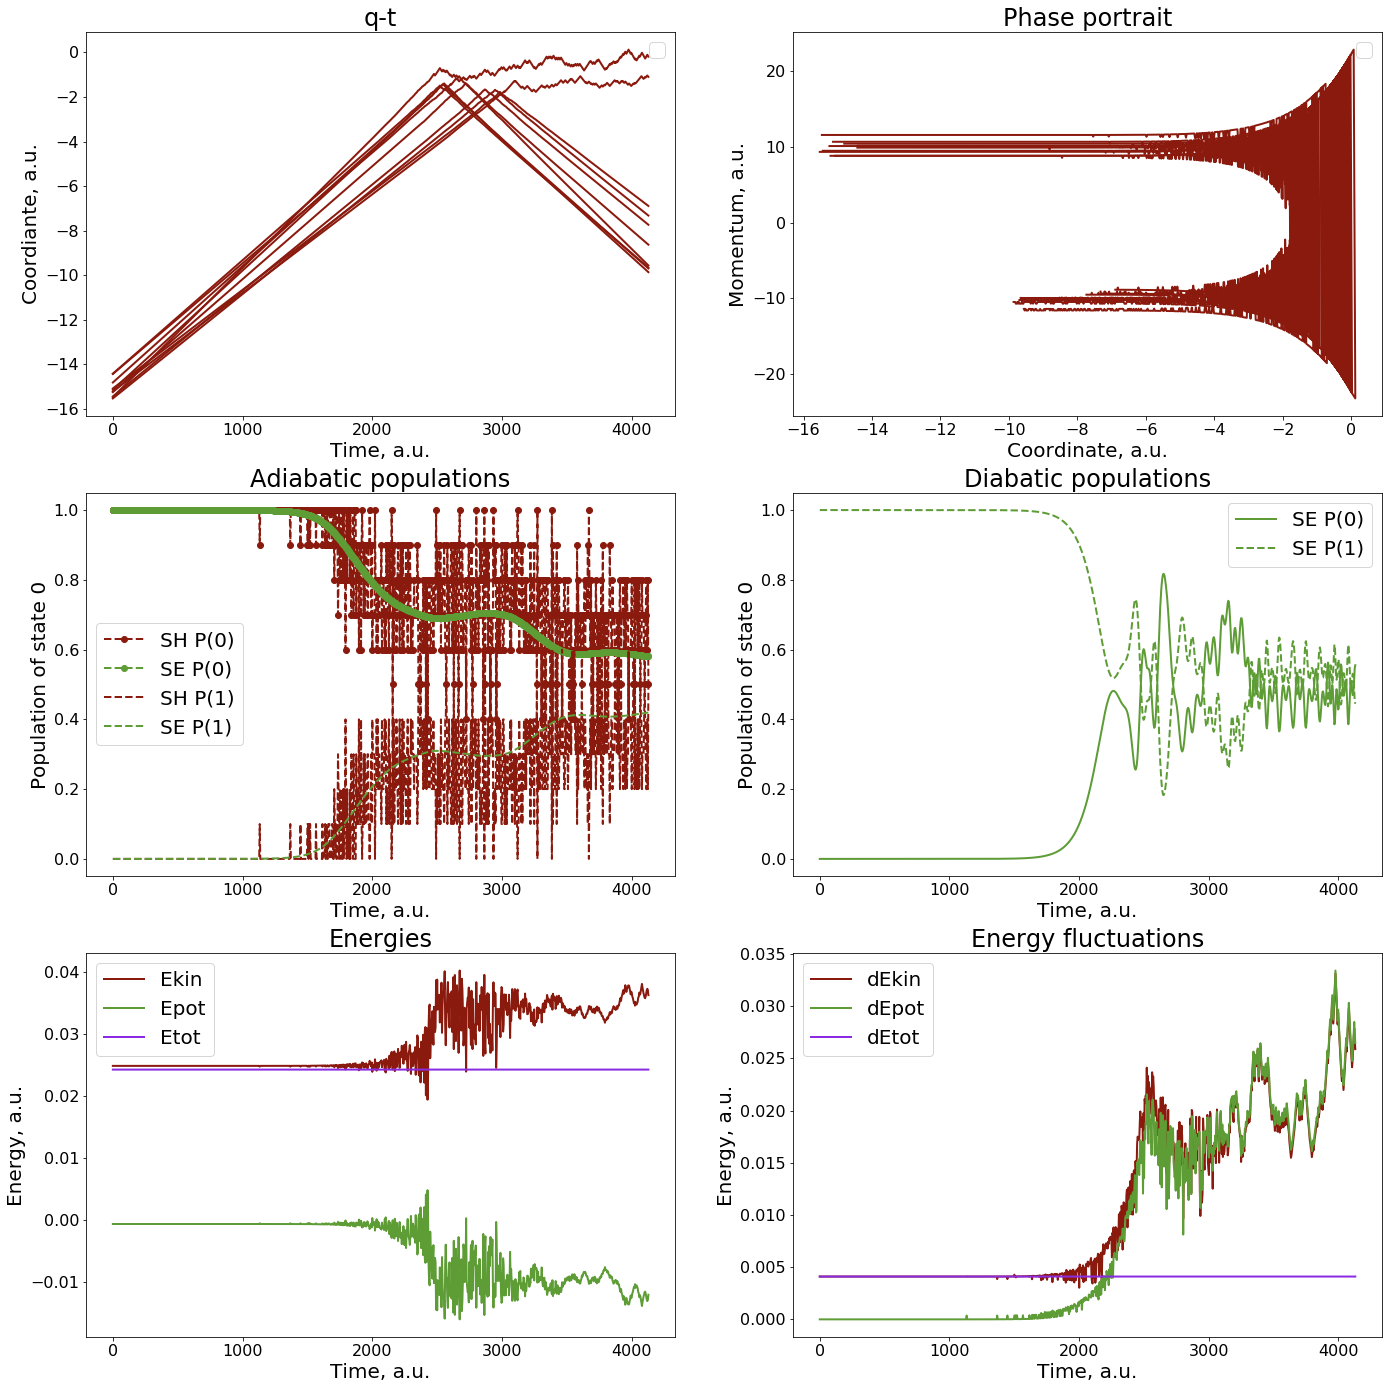

In [12]:
# If you want to just read the computed properties
#res3 = read_results_multi("T_test1", 2, len(init_elec["istates"]), len(init_elec["istates"]), len(init_cond[0][0]), ntraj, len(init_cond))

for res_i in res3:
    plot_dyn(res_i)

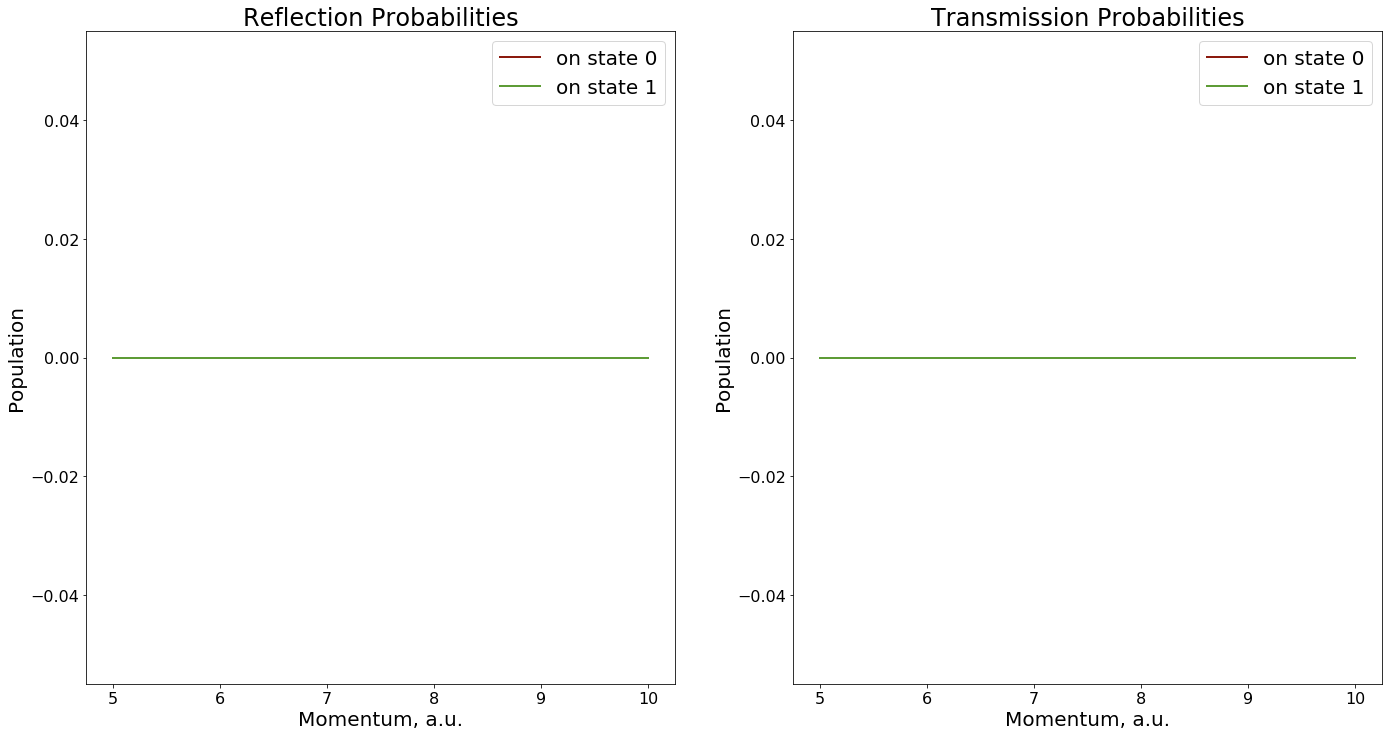

In [13]:
scat_params = {"act_dof":0, "left_boundary":-12.0, "right_boundary":6.0}
plot_scattering(init_cond, res3, scat_params)